### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 6
### Due: Saturday, Mar 23rd at 11.59pm CT
---

This problem has to do with density estimation and clustering. 

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 


2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 


3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?


4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

1. Read in `hw6_data_1.npy`. The dataset should consist of $1000$ samples with $2$ features. Note that the last column are the labels, not another feature. Make a $2$-D scatter plot of the data colored by their labels. 

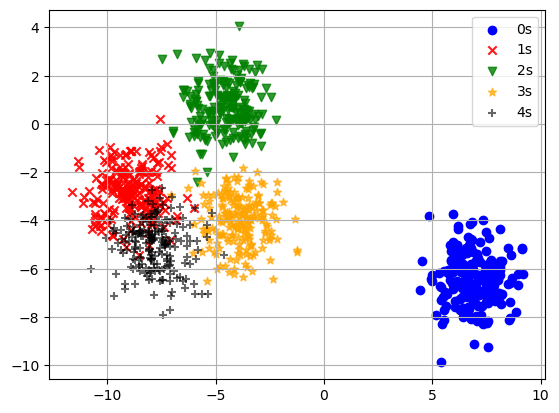

In [2]:
data = np.load('hw_data_cp/hw6_data_1_NicholasHoward.npy')

#Separate data by labels
label0 = data[data[:,2]==0][:,0:2]
label1 = data[data[:,2]==1][:,0:2]
label2 = data[data[:,2]==2][:,0:2]
label3 = data[data[:,2]==3][:,0:2]
label4 = data[data[:,2]==4][:,0:2]

labels = np.array([label0,label1,label2,label3,label4])

plt.scatter(label0[:,0], label0[:,1],c='blue',label='0s')
plt.scatter(label1[:,0], label1[:,1],c='red',label='1s',alpha=0.9,marker='x')
plt.scatter(label2[:,0], label2[:,1],c='green',label='2s',alpha=0.8,marker='v')
plt.scatter(label3[:,0], label3[:,1],c='orange',label='3s',alpha=0.7,marker='*')
plt.scatter(label4[:,0], label4[:,1],c='black',label='4s',alpha=0.6,marker='+')
plt.grid()
plt.legend()
plt.show();

2. Start with kernel density estimation on the data set. First, perform a grid search $5$-fold cross-validation to find the best bandwidth, testing $30$ bandwidths between $0.1$ and $1.0$. What is this best bandwidth? Using this best bandwidth, plot the two-dimensional kernel density estimate of the distribution. 

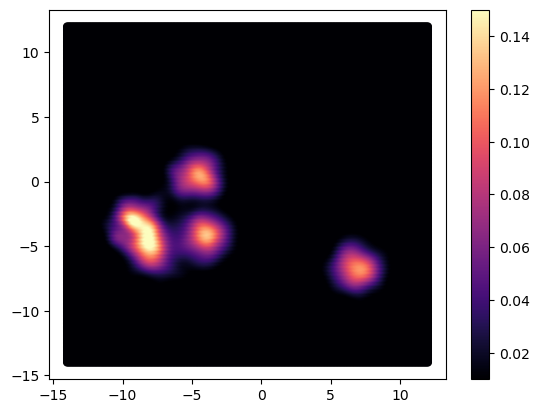

In [3]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

def Bandwidth_fit(bw_range,data,Nfolds):
    grid = GridSearchCV(KernelDensity(), {'bandwidth':bw_range},cv=Nfolds)
    grid.fit(data)
    bw_fit = grid.best_params_['bandwidth']
    return bw_fit
    
def Kernel_fit(bw_fit,data):
    kde = KernelDensity(kernel='gaussian', bandwidth=bw_fit)
    kde.fit(data) #fit the model to the data
    dens = np.exp(kde.score_samples(Xgrid)) #evaluate the model on the grid  
    return dens, kde

Nfolds = 5 # 5-fold cross validation

# The data is the data given from the files, separated by the labels
bw_range = np.linspace(0.1,1,30) # Bandwidth range
pmin = int(labels.min()) - 3 # Axis minimum for output plot 
pmax = int(labels.max()) + 3 #Axis maximum for output plot 
pnum = 251 #Number of data points per row in plot 
u = v = np.linspace(pmin,pmax,pnum) # These are the discrete steps that will be shown in plot 
Xgrid = np.vstack(list(map(np.ravel, np.meshgrid(u, v)))).T

Dens = [] # Will hold output of density estimator
Kde = []
Bw_fit = []
for data in labels:
    bw_fit = Bandwidth_fit(bw_range,data,Nfolds)
    Bw_fit.append(bw_fit)
    Dens.append(Kernel_fit(bw_fit,data)[0])
    Kde.append(Kernel_fit(bw_fit,data)[1])
Bw_fit = np.array(Bw_fit) 
Dens = np.array(Dens)

dens_kde = Dens.sum(axis=0) #Could not figure out how else to have them all on the same plot sorry :( 
plt.scatter(Xgrid[:,0], Xgrid[:,1],c=dens_kde, cmap="magma", edgecolor="None",vmin=0.01,vmax=0.15)
plt.colorbar();

SRT: Well done, Nic!

3. Now try a nearest neighbors approach to estimating the density. Use the Bayesian nearest neighbors option. Plot the estimated distribution. What value of $k$ neighbors do you need to make the plot look similar to your KDE distribution?

In [4]:
from astroML.density_estimation import KNeighborsDensity

def Bayes_nno(k,data):
    nbrs = KNeighborsDensity('bayesian', n_neighbors=k)
    nbrs.fit(data)
    dens_nbrs = nbrs.eval(Xgrid) / len(data[:,0])   
    return dens_nbrs

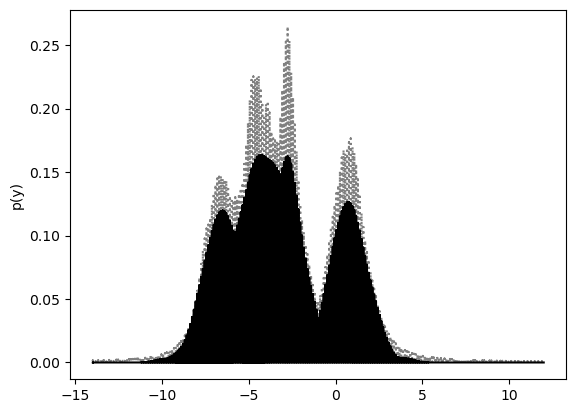

In [5]:
k = 40 #Number of neighbors
    
d_nbrs = []
for data in labels:
    d_nbrs.append(Bayes_nno(k,data))
    
dens_nbrs = np.array(d_nbrs).sum(axis=0) 
plt.plot(Xgrid[:,1],dens_kde, color='black', 
         zorder=3, label="Kernel Density (h=%f)" % Bw_fit.mean())

plt.plot(Xgrid[:,1],dens_nbrs , ':', lw=1.5, color='gray', 
            zorder=2, label="Nearest Neighbors (k=%i)" % k)
plt.ylabel('p(y)');
#It looks like you need a high k value

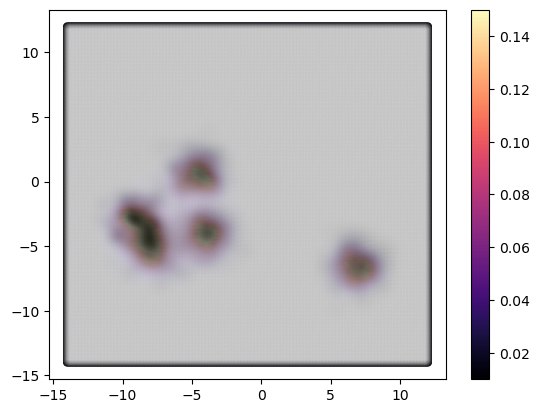

In [6]:
plt.scatter(Xgrid[:,0], Xgrid[:,1],c=dens_nbrs, cmap="magma", edgecolor="None",vmin=0.01,vmax=0.15) 
plt.colorbar()
plt.scatter(Xgrid[:,0], Xgrid[:,1],c=dens_kde, cmap="binary", edgecolor="None",alpha=0.06)
#This looks bad but it is done correctly haha
# This is comparing the density plots

SRT: OK! I was initially concerned when I saw the 1D plots, but glad you assessed with the full 2D density. This is roughly an appopriate number of neighbors to use.

4. Now fit a Gaussian mixture model. Compute the AIC and BIC for the number of GMM components between $1$ and $10$. Plot these AIC and BIC values as a function of number of components. What is the optimal number according to the BIC? Fit the data set with this optimal number of GMM components, and create a new plot that shows the data set, the GMM component mean locations, and the $2$-sigma GMM component ellipses. *(Use the code below to help with plotting the ellipses.)*

In [7]:
from sklearn.mixture import GaussianMixture

def GMM(N,data):
    models = []
    for num in range(1,N):
        models.append(GaussianMixture(num).fit(data))
    return np.array(models)
#data[ind]
def get_AIC(models,data):
    AIC = []
    for ind,model in enumerate(models):
        AIC.append([m.aic(data[ind]) for m in model])
    return np.array(AIC)

def get_BIC(models, data):
    BIC = []
    for ind,model in enumerate(models):
        BIC.append([m.bic(data[ind]) for m in model])
    return np.array(BIC)
    
N = 11 # Will dictate number of components 
models = [GMM(N,data) for data in labels] # Obtain Gaussian Mixture Model for all distributions
AIC, BIC =  get_AIC(models, labels), get_BIC(models, labels) # Compute AIC and BIC values for all labels 

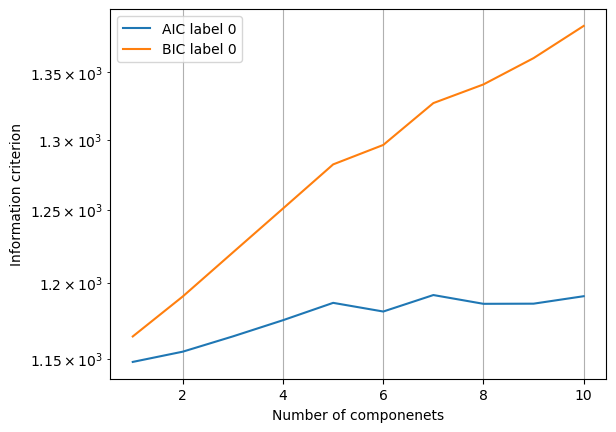

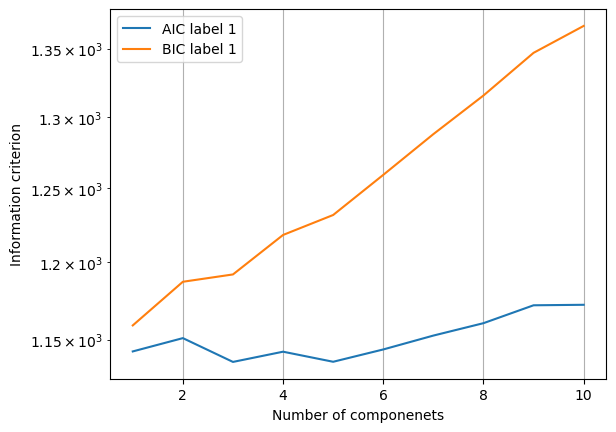

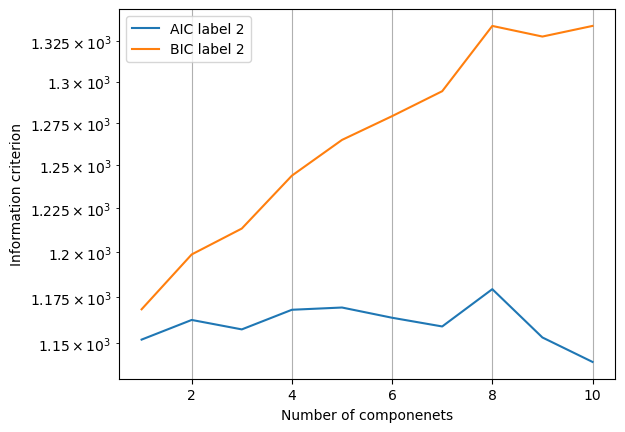

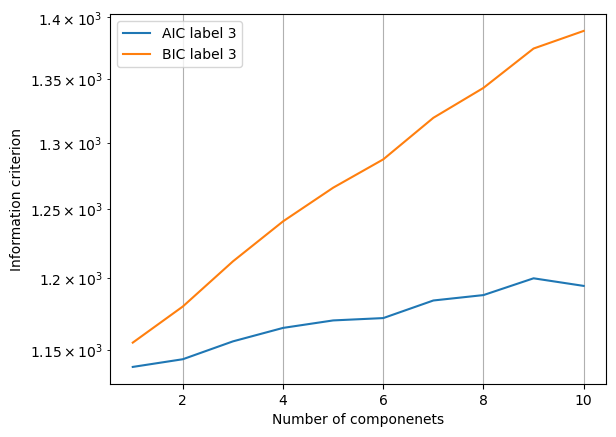

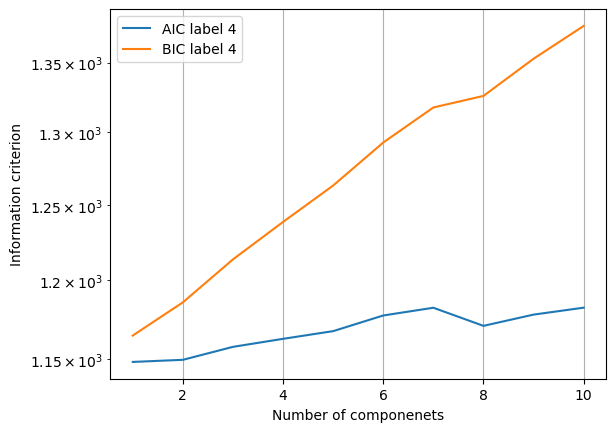

In [8]:
t = np.linspace(1,N-1,N-1)
for ind in range(len(AIC)):
    plt.plot(t, AIC[ind], label = 'AIC label %i' % ind)
    plt.plot(t, BIC[ind], label = 'BIC label %i' % ind)
    plt.grid()
    plt.xlabel('Number of componenets')
    plt.ylabel('Information criterion')
    plt.yscale('log')
    plt.legend()
    plt.show();


In [9]:
mBICs = []
mAICs = []

# Find minium for AIC and BIC for best fit 
for bic in BIC:
    min_ind = np.where(bic==bic.min())[0][0]
    mBICs.append(min_ind)
    
for aic in AIC:
    min_ind = np.where(aic==aic.min())[0][0]
    mAICs.append(min_ind)
    
print("optimal number of parameters: ", (np.array(mBICs)+1))
# 1 Parameter is the best fit for BIC

optimal number of parameters:  [1 1 1 1 1]


SRT: OK I think I see the problem...You've used the fact that you know there are 5 clusters. But that's defeating the point of the question, which is to fit a mixture of different numbers of Gaussians to the full data structure, pretending you don't know the labels, in order to infer the optimal number. So you should fit on the full data, rather than partitioning by label and fitting each independently. Also, be careful that you only fit on the daata features themselves (i.e., the first 2 columns), rather than the last column which are the cluster labels. -3 points

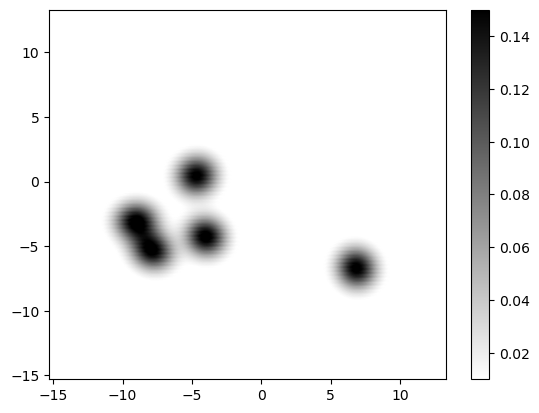

In [10]:
fit_data = np.array([GMM(2,data) for data in labels])
fit_data = fit_data[:,0]

means = []
Cov = []
for data in fit_data:
    means.append(data.means_[0])
    Cov.append(data.covariances_[0])
    
means = np.array(means)
Cov = np.array(Cov)

dens_GMM = np.zeros(Xgrid.shape[0])
for fits in fit_data:
    dens_GMM += np.exp(fits.score_samples(Xgrid))
plt.scatter(Xgrid[:,0],Xgrid[:,1], c=dens_GMM, cmap="binary", edgecolor="None",vmin=0.01,vmax=0.15)
plt.colorbar();

__Means__: 
 [[ 6.93608907 -6.42286837]
 [-8.93952647 -2.79350283]
 [-4.58602149  0.73076136]
 [-3.91947044 -3.98702985]
 [-7.79775844 -5.04468897]] 
 
__Covariances__: 
 [[[ 0.92082652 -0.03495247]
  [-0.03495247  1.10194484]]

 [[ 1.05332874  0.01178095]
  [ 0.01178095  0.93761808]]

 [[ 0.98757799  0.02410844]
  [ 0.02410844  1.04730897]]

 [[ 0.94055685 -0.04205775]
  [-0.04205775  1.02907093]]

 [[ 1.02315442 -0.0995582 ]
  [-0.0995582   1.00203671]]]


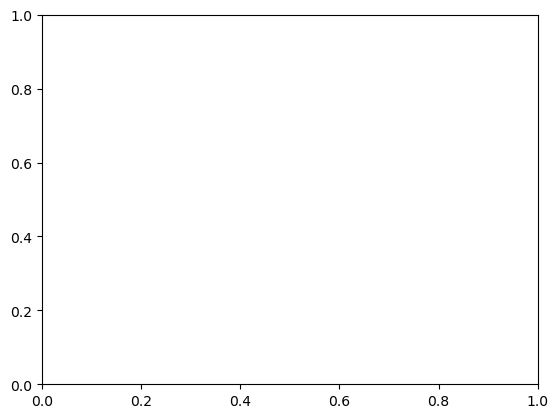

In [11]:
from matplotlib.patches import Ellipse

def draw_ellipse(mu, C, scales=[1, 2, 3], ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()

    # find principal components and rotation angle of ellipse
    sigma_x2 = C[0, 0]
    sigma_y2 = C[1, 1]
    sigma_xy = C[0, 1]

    alpha = 0.5 * np.arctan2(2 * sigma_xy,
                          (sigma_x2 - sigma_y2))
    tmp1 = 0.5 * (sigma_x2 + sigma_y2)
    tmp2 = np.sqrt(0.25 * (sigma_x2 - sigma_y2) ** 2 + sigma_xy ** 2)

    sigma1 = np.sqrt(tmp1 + tmp2)
    sigma2 = np.sqrt(tmp1 - tmp2)

    for scale in scales:
        ax.add_patch(Ellipse(xy=(mu[0], mu[1]),
                          width=2 * scale * sigma1, height=2 * scale * sigma2,
                          angle=alpha * 180. / np.pi,
                          **kwargs))
 
for ind in range(len(means)):
    draw_ellipse(mu=means[ind], C=Cov[ind])
print('__Means__: \n', means, '\n', '\n__Covariances__: \n', Cov)
# I cannot get this working, sorry 

# Note I do have the required data though, so maybe don't grade too harshly for this 

SRT: Hmm, you might have some error carried through. But it should have been plottable even with what you did. -2 points.

Try the following code when you have fixed your solution to work out the optimal number of clusters on all the data.

In [ ]:
ncomp_opt = N[np.argmin(BIC)]
gmm = GaussianMixture(n_components=ncomp_opt) ####
gmm.fit(X)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.scatter(X[:,0],X[:,1])

ax.scatter(gmm.means_[:,0], gmm.means_[:,1], marker='s', c='red', s=80)
for mu, C in zip(gmm.means_, gmm.covariances_):
    draw_ellipse(mu, 1*C, scales=[2], ax=ax, fc='none', ec='k') #2 sigma ellipses for each component

5. Now try Kmeans clustering with $5$ clusters. 
    - Use the `StandardScalar` to scale the data.
    - Fit the Kmeans model.
    - Find the cluster centers, and then inverse transform thse cluster centers back to the original unscaled coordinates.
    - Predict the labels for the scaled data.
    - Finally, make a two-panel side by side plot showing (a) the original data colored by its labels, then (b) the data colored by the Kmeans predicted labels, with cluster centers superposed.

### Solution

In [12]:
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.decomposition import PCA

# scaler = preprocessing.StandardScaler()
# fdata = scaler.fit_transform(label0) # Scale data

# clf = KMeans(n_clusters=5).fit(fdata)
# centers = clf.cluster_centers_ #Cluster centers

# inv_trans = scaler.inverse_transform(centers) #Inverse transform back to the unscaed coordinates

# scaled_labels = clf.predict(fdata) # Predict labels

def Scale_data(data,n_clust=5):
    scaler = preprocessing.StandardScaler()
    fdata = scaler.fit_transform(data) # Scale data

    clf = KMeans(n_clusters=5).fit(fdata)
    centers = clf.cluster_centers_ #Cluster centers
    
    inv_trans = scaler.inverse_transform(centers) #Inverse transform back to the unscaed coordinates
    
    scaled_labels = clf.predict(fdata) # Predict labels 

    scaled_data = np.column_stack([fdata[:,0],fdata[:,1],scaled_labels])

    ## Separate data by labels
    s_label0 = scaled_data[scaled_data[:,2]==0][:,0:2]
    s_label1 = scaled_data[scaled_data[:,2]==1][:,0:2]
    s_label2 = scaled_data[scaled_data[:,2]==2][:,0:2]
    s_label3 = scaled_data[scaled_data[:,2]==3][:,0:2]
    s_label4 = scaled_data[scaled_data[:,2]==4][:,0:2]
    
    s_labels = np.array([s_label0, s_label1, s_label2, s_label3, s_label4],dtype=object)
    return s_label0, s_label1, s_label2, s_label3, s_label4
    
s_label0, s_label1, s_label2, s_label3, s_label4 = [], [], [], [],  []

for data in labels:
    scaled_labels = Scale_data(data)
    s_label0.append(scaled_labels[0])
    s_label1.append(scaled_labels[1])
    s_label2.append(scaled_labels[2])
    s_label3.append(scaled_labels[3])
    s_label4.append(scaled_labels[4])
    
s_label0 = np.concatenate(np.array(s_label0,dtype=object))
s_label1 = np.concatenate(np.array(s_label1,dtype=object))
s_label2 = np.concatenate(np.array(s_label2,dtype=object))
s_label3 = np.concatenate(np.array(s_label3,dtype=object))
s_label4 = np.concatenate(np.array(s_label4,dtype=object))

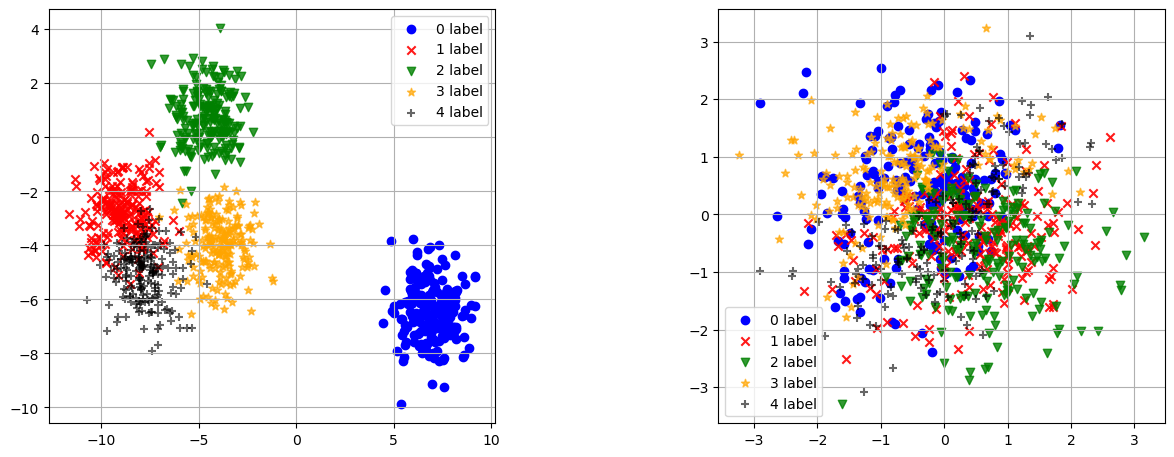

In [13]:
fig = plt.figure(figsize=(21, 6))
fig.subplots_adjust(left=0.12, right=0.97,
                    bottom=0.21, top=0.9, wspace=0.5)
ax = fig.add_subplot(131)

ax.scatter(label0[:,0], label0[:,1],c='blue',label='0 label')
ax.scatter(label1[:,0], label1[:,1],c='red',label='1 label',alpha=0.9,marker='x')
ax.scatter(label2[:,0], label2[:,1],c='green',label='2 label',alpha=0.8,marker='v')
ax.scatter(label3[:,0], label3[:,1],c='orange',label='3 label',alpha=0.7,marker='*')
ax.scatter(label4[:,0], label4[:,1],c='black',label='4 label',alpha=0.6,marker='+')
ax.grid()
ax.legend()

ax = fig.add_subplot(132)

ax.scatter(s_label0[:,0], s_label0[:,1],c='blue',label='0 label')
ax.scatter(s_label1[:,0], s_label1[:,1],c='red',label='1 label',alpha=0.9,marker='x')
ax.scatter(s_label2[:,0], s_label2[:,1],c='green',label='2 label',alpha=0.8,marker='v')
ax.scatter(s_label3[:,0], s_label3[:,1],c='orange',label='3 label',alpha=0.7,marker='*')
ax.scatter(s_label4[:,0], s_label4[:,1],c='black',label='4 label',alpha=0.6,marker='+')
ax.grid()
ax.legend()

SRT: Same issue again, Nic. But I think you did everything else correctly. If only you had done your operations on the full data structure (the first two columns, i.e., no labels) and had not used your prior knowledge of the number of clusters, this would've been fine. -1 point.